In [39]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

In [40]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(stoi)

In [41]:
# creating the dataset
context_len = 10

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * context_len
        for ch in w+'.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# creating the test/train/validation sets
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80% of the data
X_test, Y_test = build_dataset(words[n1:n2]) # 10% of the data
X_dev, Y_dev = build_dataset(words[n2:]) # 10% of the data

print('X_train.shape -->', X_train.shape, 'Y_train.shape -->', Y_train.shape)
print('X_test.shape -->', X_test.shape, 'Y_test.shape -->', Y_test.shape)
print('X_dev.shape -->', X_dev.shape, 'Y_dev.shape -->', Y_dev.shape)

X_train.shape --> torch.Size([182625, 10]) Y_train.shape --> torch.Size([182625])
X_test.shape --> torch.Size([22655, 10]) Y_test.shape --> torch.Size([22655])
X_dev.shape --> torch.Size([22866, 10]) Y_dev.shape --> torch.Size([22866])


In [42]:
# Class Definition for Linear, BatchNorm and Tanh layers, made to look like pytorch's
class Linear:
    def __init__(self, n_in, n_out, bias=True):
        self.weights = torch.randn(n_in, n_out) / (n_in ** 0.5)
        self.bias = torch.zeros(n_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        if self.bias is not None:
            return [self.weights, self.bias]
        else:
            return [self.weights]

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, moementum=0.1):
        self.eps = eps
        self.moementum = moementum
        self.training = True
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
            with torch.no_grad():
                self.running_var = (1-self.moementum) * self.running_var + self.moementum * xvar
                self.running_mean = (1-self.moementum) * self.running_mean + self.moementum * xmean
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = (self.gamma * xhat) + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [43]:
# network parameters
n_embd = 30
n_hidden = 200
batch_size = 64

C = torch.randn(vocab_size, n_embd) 
layers = [
    Linear(n_embd * context_len, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# make the softmax layer less confident in its initial predictions
with torch.no_grad():
    layers[-1].gamma *= 0.1
# boost the linear layers before the tanh by 5/3 in order to fight the squashing from tanh
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

228264


In [44]:
#model
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):
    #sampling the batch
    idx = torch.randint(0 ,X_train.shape[0], (batch_size,)) # (batch_size,)
    Xb, Yb = X_train[idx], Y_train[idx] # (batch_size, context_len), (batch_size,)

    #forward pass
    emb = C[Xb]  # (batch_size, context_len, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (batch_size, n_embd * context_len)
    logits = embcat
    for layer in layers:
        logits = layer(logits)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    # for layer in layers:
    #     layer.out.retain_grad() # use this to enable visualizations
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # append loss to lossi
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #update the update:data ratio list
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
 

      0/ 200000: 3.3199
  10000/ 200000: 2.1085
  20000/ 200000: 1.9074
  30000/ 200000: 2.0978
  40000/ 200000: 2.3334
  50000/ 200000: 1.8591
  60000/ 200000: 1.8897
  70000/ 200000: 2.0490
  80000/ 200000: 1.8262
  90000/ 200000: 1.8861
 100000/ 200000: 1.8140
 110000/ 200000: 2.0555
 120000/ 200000: 1.6224
 130000/ 200000: 1.9645
 140000/ 200000: 2.0561
 150000/ 200000: 1.9872
 160000/ 200000: 1.9317
 170000/ 200000: 1.9656
 180000/ 200000: 2.0543
 190000/ 200000: 1.8098


In [45]:
# Setting non-training mode in the BatchNorm1d layer to use the calculated mean and var 
for layer in layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

layer 2 (      Tanh): mean +0.13, std 0.78, saturated: 24.50%
layer 5 (      Tanh): mean -0.02, std 0.75, saturated: 15.00%
layer 8 (      Tanh): mean +0.09, std 0.74, saturated: 21.00%
layer 11 (      Tanh): mean -0.06, std 0.71, saturated: 14.00%
layer 14 (      Tanh): mean +0.01, std 0.69, saturated: 8.50%


Text(0.5, 1.0, 'activation distribution')

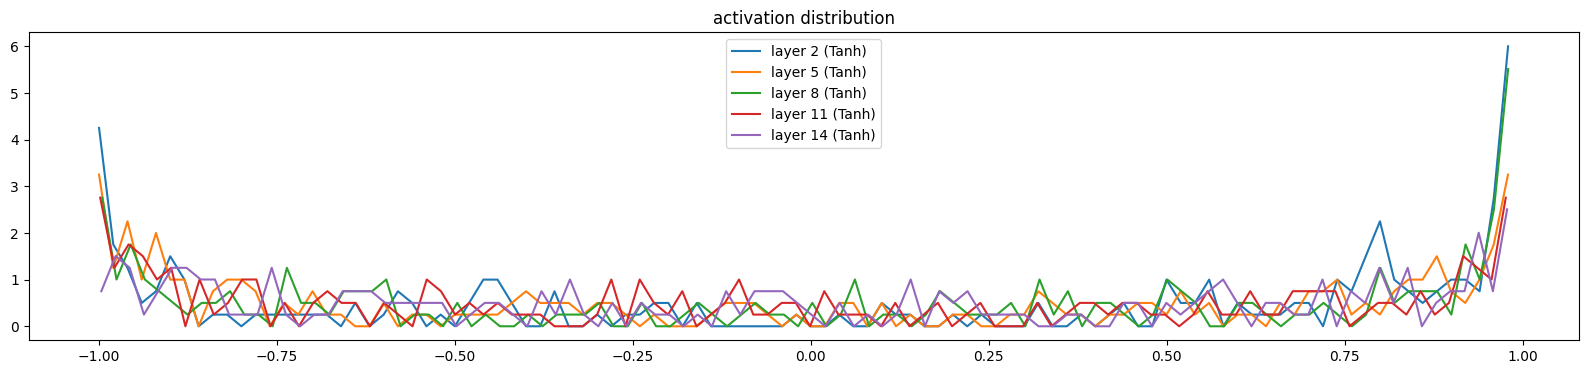

In [52]:
#visualizing forward pass activations of tanh layers
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')


In [8]:
# #visualizing forward pass activations of tanh layers
# # note: In order for this to work you need to enable retain_grad line in the training section
# plt.figure(figsize=(20,4))
# legends=[]
# for i, layer in enumerate(layers[:-1]):
#     if isinstance(layer, Tanh):
#         t = layer.out.grad
#         print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
#         hy, hx = torch.histogram(t, density=True)
#         plt.plot(hx[:-1].detach(), hy.detach())
#         legends.append(f'layer {i} ({layer.__class__.__name__})')
# plt.legend(legends)
# plt.title('activation distribution')


weight   (27, 30) | mean +0.000000 | std 9.734513e-03 | grad:data ratio 9.673402e-03
weight (300, 200) | mean -0.000004 | std 4.104540e-03 | grad:data ratio 2.581638e-02
weight (200, 200) | mean +0.000019 | std 4.661594e-03 | grad:data ratio 2.626066e-02
weight (200, 200) | mean +0.000014 | std 4.590143e-03 | grad:data ratio 2.720734e-02
weight (200, 200) | mean -0.000033 | std 3.899917e-03 | grad:data ratio 2.463005e-02
weight (200, 200) | mean -0.000035 | std 3.109820e-03 | grad:data ratio 2.088166e-02
weight  (200, 27) | mean -0.000015 | std 6.206895e-03 | grad:data ratio 2.395352e-02


Text(0.5, 1.0, 'activation distribution')

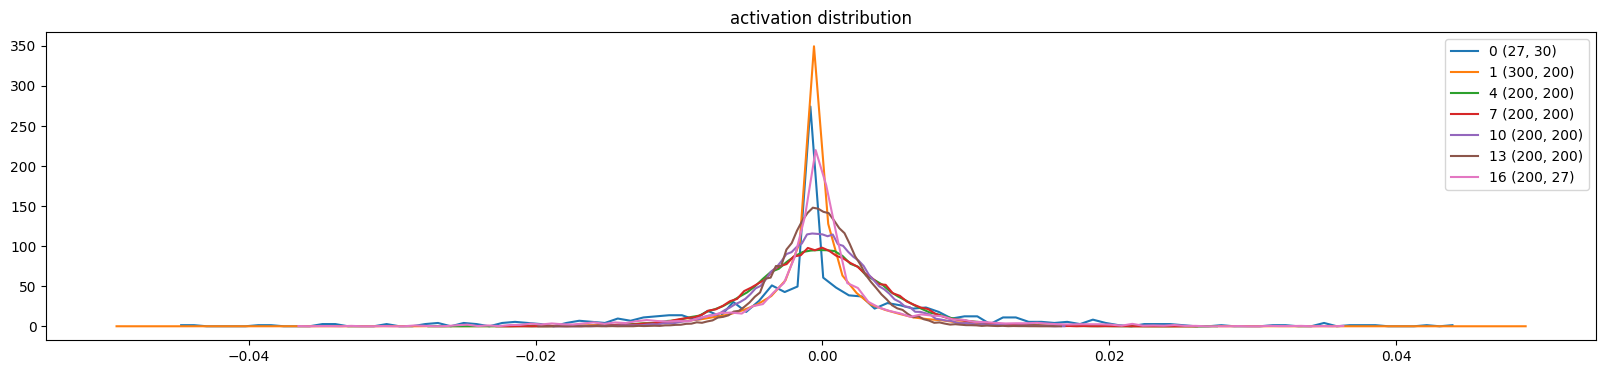

In [53]:
#visualizing forward pass activations of tanh layers
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('activation distribution')


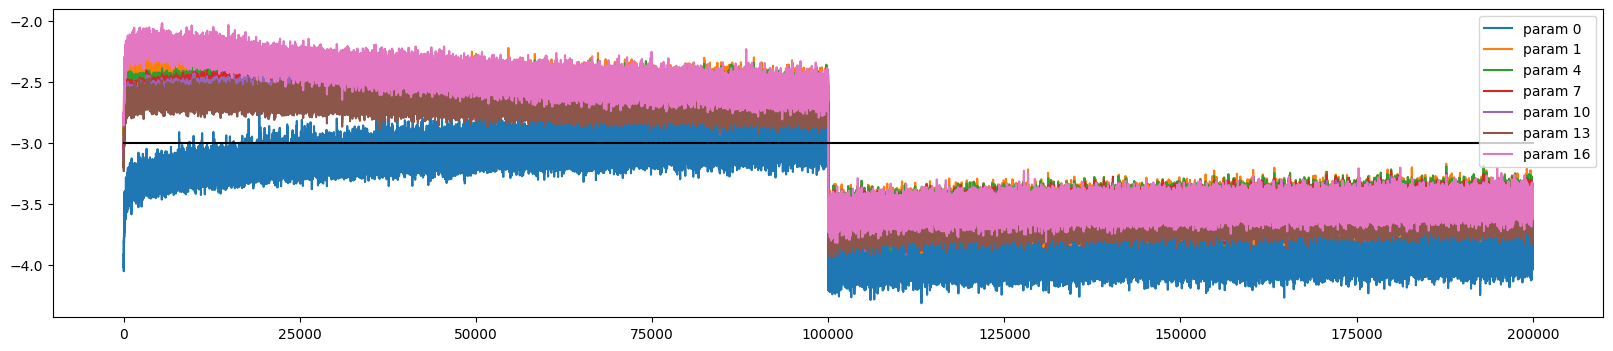

In [54]:
#visualizing forward pass activations of tanh layers
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)

In [55]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'test' : (X_test, Y_test),
        'train' : (X_train, Y_train),
        'dev' : (X_dev, Y_dev)
    }[split]
    emb = C[x]  # (batch_size, context_len, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (batch_size, n_embd * context_len)
    logits = embcat
    for layer in layers:
        logits = layer(logits)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')

split_loss('train')
split_loss('test')
split_loss('dev')

train loss: 1.6545
test loss: 2.0120
dev loss: 2.0134


In [50]:
# before any optimizations
    # train loss: 2.1190
    # test loss: 2.1607
    # dev loss: 2.1675

# Fixing the initialization of the w2 and setting b2 to zero 
    # train loss: 2.0693
    # test loss: 2.1332
    # dev loss: 2.1368

# Fixing the oversaturation of the tanh layer by scaling down the w1 and b1
    # train loss: 2.0343
    # test loss: 2.1023
    # dev loss: 2.1058

# Loss after adding batch normalization
    # train loss: 2.0668
    # test loss: 2.1048
    # dev loss: 2.1065

# Adding batchnorm layer
    # train loss: 2.0123
    # test loss: 2.0841
    # dev loss: 2.0846

# Fiddled with hyper parameters -> n_embd = 30, n_hidden = 200, batch_size = 64, max_steps = 200000, batch_size = 32
    # train loss: 1.6545
    # test loss: 2.0120
    # dev loss: 2.0134

In [64]:
# sampling from the model
for _ in range(10):
    str = ''
    idx = [0] * context_len
    while True:
        emb = C[torch.tensor([idx])]
        embcat = emb.view(emb.shape[0], -1) # (batch_size, n_embd * context_len)
        logits = embcat
        for layer in layers:
            logits = layer(logits)
        probs = F.softmax(logits, dim=1)
        new_idx = torch.multinomial(probs, num_samples=1).item()
        if new_idx == 0:
            break;
        str += itos[new_idx]
        idx = idx[1:] + [new_idx]
    print(str)
    

victoriano
treyghe
yovanna
minkoor
reveigh
ashmia
tova
keselyn
maximire
louise
